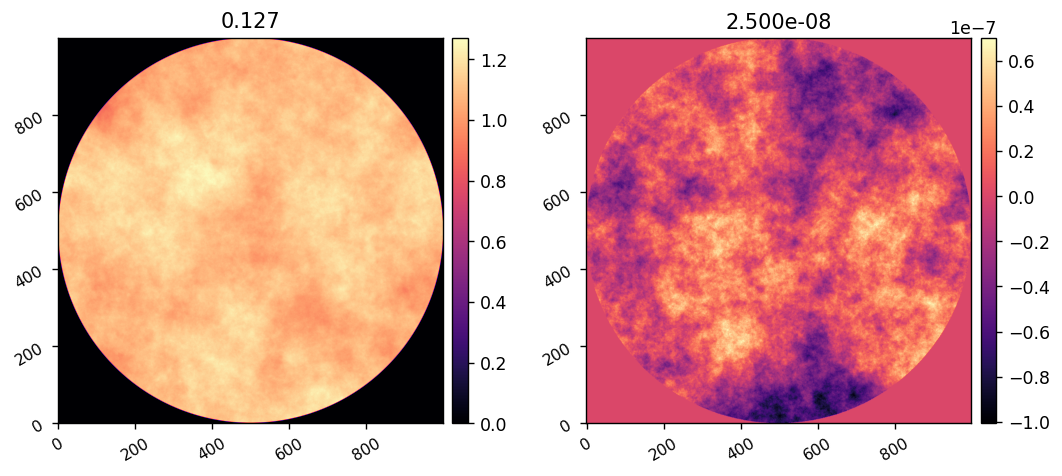

In [1]:

import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload

from matplotlib.patches import Circle

import scoobpsf
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.compact_scoob_2 as cscoob
import scoobpsf.dm as dm

import lina

npsf = 200

wavelength = 633*u.nm
pupil_diam = 6.75*u.mm

reload(utils)
npix = 1000
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=25*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')
lina.utils.rms(wfe_opd[mask])

scc_position = (15/2.5*u.mm, 0*u.mm)

influence function sampling 31.914893617021274
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


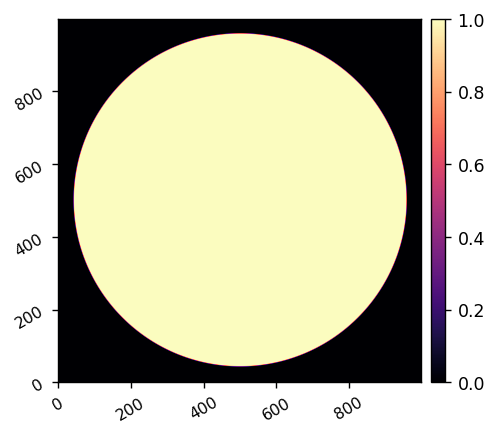

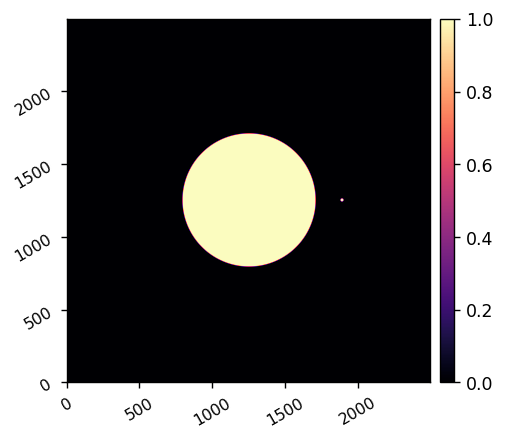

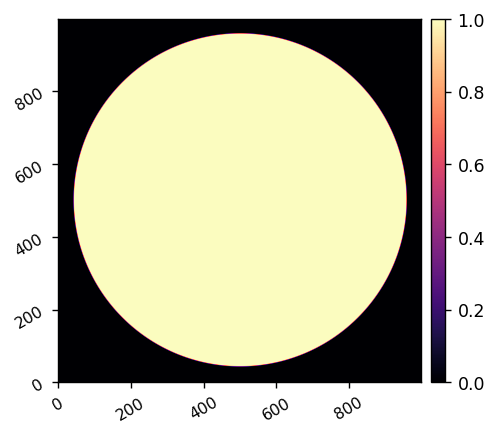

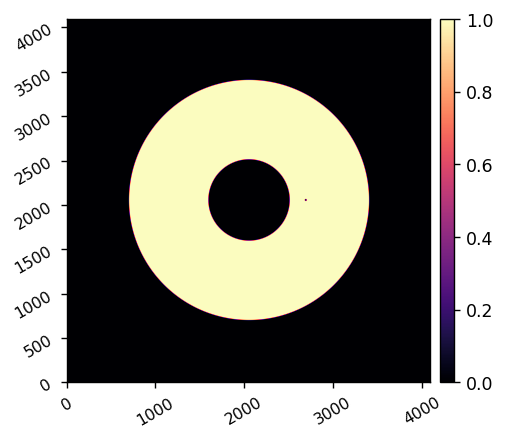

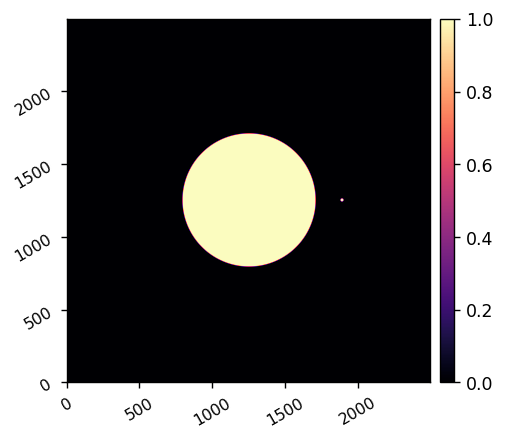

In [20]:
reload(cscoob)
model = cscoob.CORO(scc_pinhole_position=scc_position)
model.scc_diam = 200*u.um
imshow1(model.LYOT)

model.use_scc()
imshow1(model.LYOT)

model.use_scc(False)
imshow1(model.LYOT)

model.use_llowfsc()
imshow1(model.LYOT)

model.use_llowfsc(False)
imshow1(model.LYOT)

influence function sampling 31.914893617021274
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


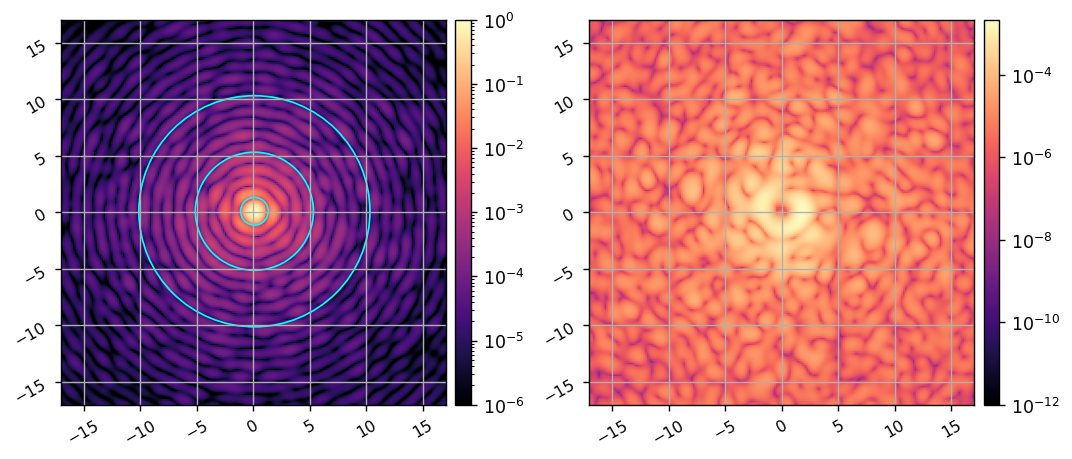

In [26]:
reload(cscoob)
reload(scoobpsf.props)
model = cscoob.CORO()
model.scc_diam = 300*u.um
model.scc_pinhole_position = scc_position
model.use_scc()

model.WFE = WFE
ref_psf = model.snap()
model.Imax_ref = xp.max(ref_psf)

model.use_fpm = True

wfs = model.calc_wfs()
im = xp.abs(wfs[-1])**2

imshow2(ref_psf/model.Imax_ref, im, lognorm=True, vmin1=1e-6, vmin2=1e-12,
        pxscl=model.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+4, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+9, fill=False, color='cyan')])

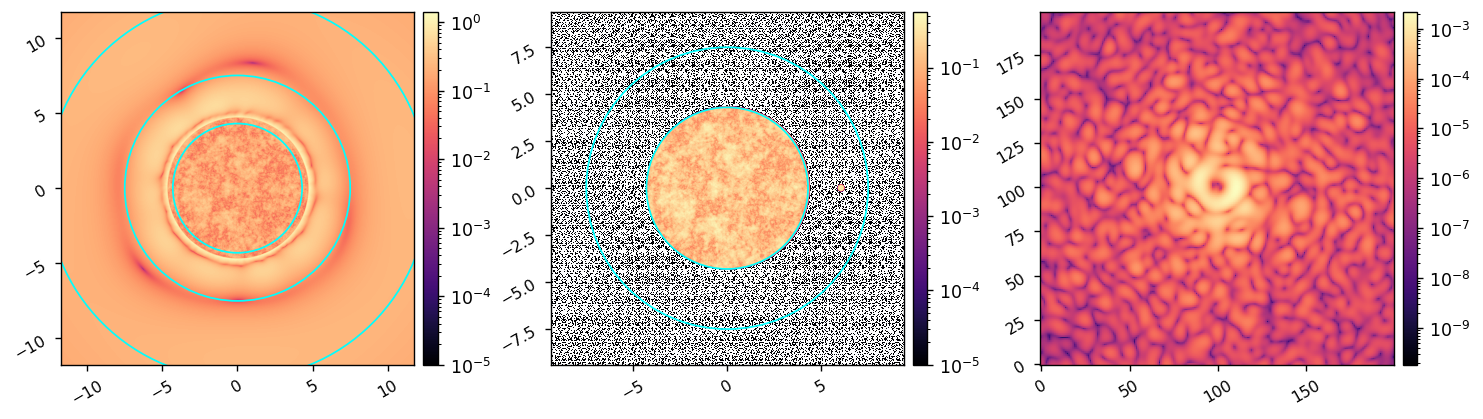

In [28]:
imshow3(xp.abs(wfs[-3]), xp.abs(wfs[-2]), im, 
        npix2=2*model.npix, 
        lognorm1=True, vmin1=1e-5, 
        lognorm2=True, vmin2=1e-5, 
        lognorm3=True,
        pxscl1=model.lyot_pupil_diam/model.npix, pxscl2=model.lyot_pupil_diam/model.npix,
        patches1=[Circle((0,0), 8.6/2, fill=False, color='cyan'),
                  Circle((0,0), 15/2, fill=False, color='cyan'),
                  Circle((0,0), 25.4/2, fill=False, color='cyan'),],
        patches2=[Circle((0,0), 8.6/2, fill=False, color='cyan'),
                  Circle((0,0), 15/2, fill=False, color='cyan'),],
                  )

influence function sampling 31.914893617021274
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


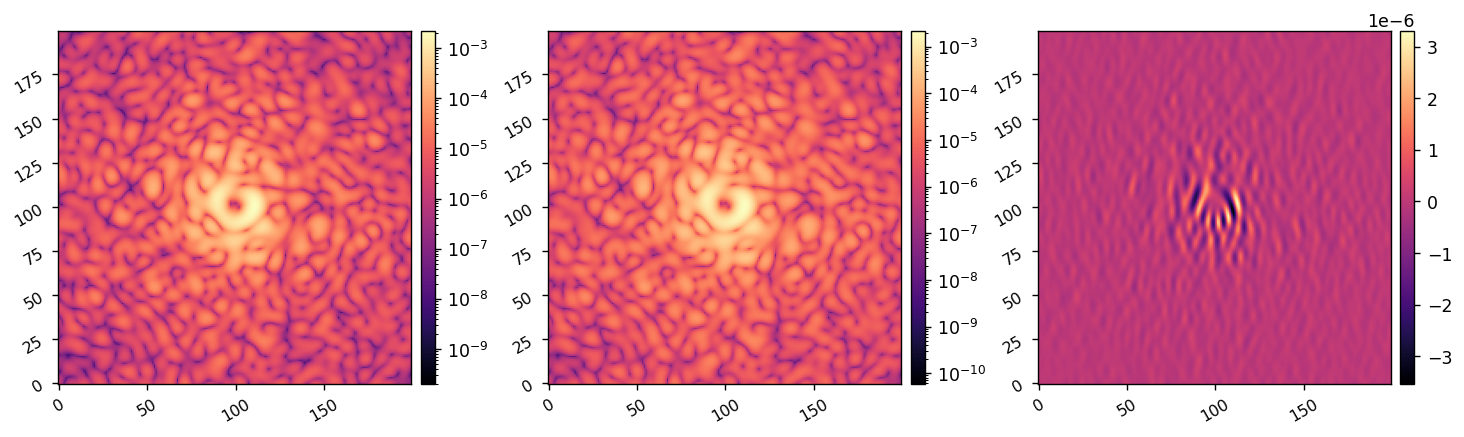

In [31]:
reload(cscoob)
reload(scoobpsf.props)

# Regular model
model = cscoob.CORO()
model.WFE = WFE
model.scc_diam = 100*u.um
model.scc_pinhole_position = scc_position

ref_psf = model.snap()
model.Imax_ref = xp.max(ref_psf)

model.use_fpm = True

model.use_scc(False)
coro_im = model.snap()

model.use_scc()
scc_im = model.snap()

diff = coro_im - scc_im
imshow3(coro_im, scc_im, diff, 
        lognorm1=True, lognorm2=True,)



In [32]:
def estimate_coherent_modulated(sysi, r_npix=0, shift=(0,0), dark_mask=None, plot=False, plot_est=False):
    '''
    r_npix:
        radius of sidebands in units of pixels
    shift:
        location of sideband centers in pixels (from center of array)
    '''

    im = sysi.snap()
    
    if dark_mask is not None:
        im *= dark_mask

    im_max = im.max()
    
    im_fft = xp.fft.fftshift(xp.fft.ifft2(xp.fft.ifftshift(im), norm='ortho'))
    # im_fft_sum = xp.sum(xp.abs(im_fft))
    
    if plot:
        imshow2(xp.abs(im_fft), xp.angle(im_fft), lognorm1=True)
    im_fft_shift = _scipy.ndimage.shift(im_fft, shift)
    
    x = xp.linspace(-im.shape[0]//2, im.shape[0]//2-1, im.shape[0]) + 1/2
    x,y = xp.meshgrid(x,x)
    
    r = xp.sqrt(x**2 + y**2)
    mask = r<r_npix
    im_fft_masked = mask*im_fft_shift
    
    # im_fft_masked_sum = xp.sum(xp.abs(im_fft_masked))
    # im_fft_masked *= xp.sqrt((im_fft_sum-im_fft_masked_sum)/im_fft_masked_sum)
    
    if plot:
        fig,ax = imshow3(mask, xp.abs(im_fft_shift), xp.abs(im_fft_masked), lognorm2=True, lognorm3=True,
                         display_fig=False, return_fig=True)
        ax[1].grid()
        ax[1].set_xticks(np.linspace(0, im_fft_shift.shape[0], 7))
        ax[1].set_yticks(np.linspace(0, im_fft_shift.shape[0], 7))

        display(fig)
    
    E_est = xp.fft.ifftshift(xp.fft.fft2(xp.fft.fftshift(im_fft_masked), norm='ortho'))

    if dark_mask is not None:
        E_est *= dark_mask

    norm = (xp.abs(E_est) ** 2).max()
    E_est *= xp.sqrt(im_max / norm)

    if plot or plot_est:
        imshow2(xp.abs(E_est)**2, xp.angle(E_est), lognorm1=True, pxscl=sysi.psf_pixelscale_lamD)

    return E_est

In [33]:
def estimate_coherent(sysi, r_npix=0, shift=(0,0), dark_mask=None, plot=False, plot_est=False):
    '''
    r_npix:
        radius of sidebands in units of pixels
    shift:
        location of sideband centers in pixels (from center of array)
    '''

    im = sysi.snap()
    
    if dark_mask is not None:
        im *= dark_mask

    im_max = im.max()
    
    im_fft = xp.fft.fftshift(xp.fft.ifft2(xp.fft.ifftshift(im), norm='ortho'))
    # im_fft_sum = xp.sum(xp.abs(im_fft))
    
    if plot:
        imshow2(xp.abs(im_fft), xp.angle(im_fft), lognorm1=True)
    im_fft_shift = _scipy.ndimage.shift(im_fft, shift)
    
    x = xp.linspace(-im.shape[0]//2, im.shape[0]//2-1, im.shape[0]) + 1/2
    x,y = xp.meshgrid(x,x)
    
    r = xp.sqrt(x**2 + y**2)
    mask = r<r_npix
    im_fft_masked = mask*im_fft_shift
    
    # im_fft_masked_sum = xp.sum(xp.abs(im_fft_masked))
    # im_fft_masked *= xp.sqrt((im_fft_sum-im_fft_masked_sum)/im_fft_masked_sum)
    
    if plot:
        fig,ax = imshow3(mask, xp.abs(im_fft_shift), xp.abs(im_fft_masked), lognorm2=True, lognorm3=True,
                         display_fig=False, return_fig=True)
        ax[1].grid()
        ax[1].set_xticks(np.linspace(0, im_fft_shift.shape[0], 7))
        ax[1].set_yticks(np.linspace(0, im_fft_shift.shape[0], 7))

        display(fig)
    
    E_est = xp.fft.ifftshift(xp.fft.fft2(xp.fft.fftshift(im_fft_masked), norm='ortho'))

    if dark_mask is not None:
        E_est *= dark_mask

    norm = (xp.abs(E_est) ** 2).max()
    E_est *= xp.sqrt(im_max / norm)

    if plot or plot_est:
        imshow2(xp.abs(E_est)**2, xp.angle(E_est), lognorm1=True, pxscl=sysi.psf_pixelscale_lamD)

    return E_est

    

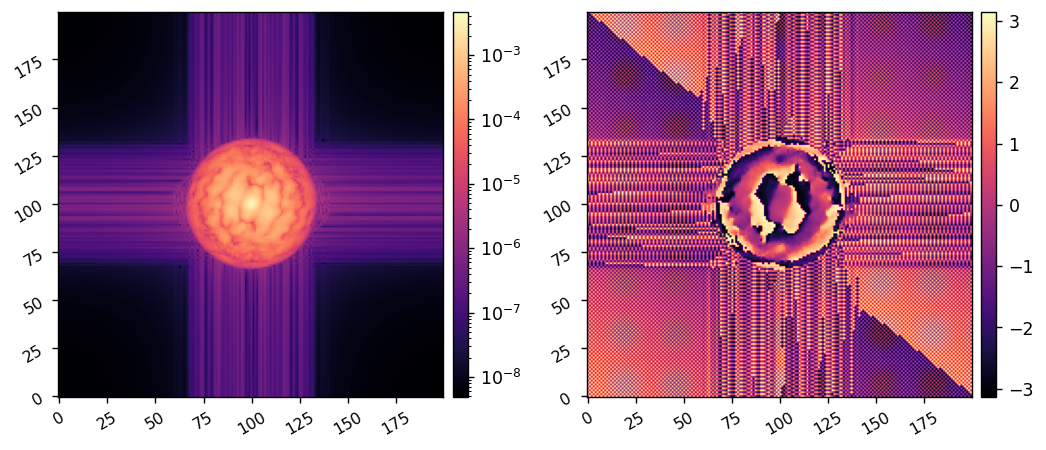

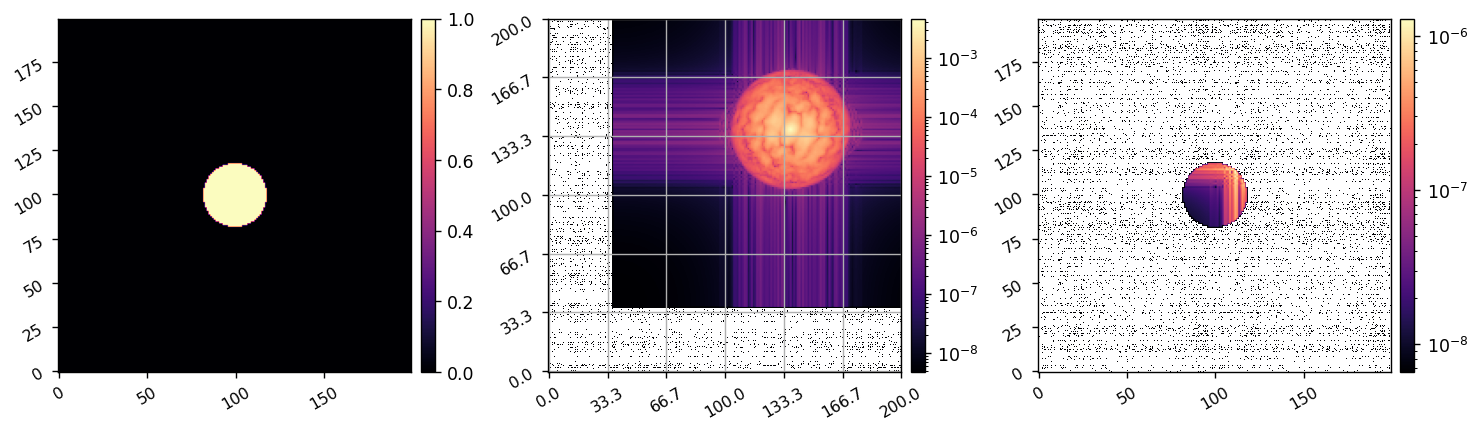

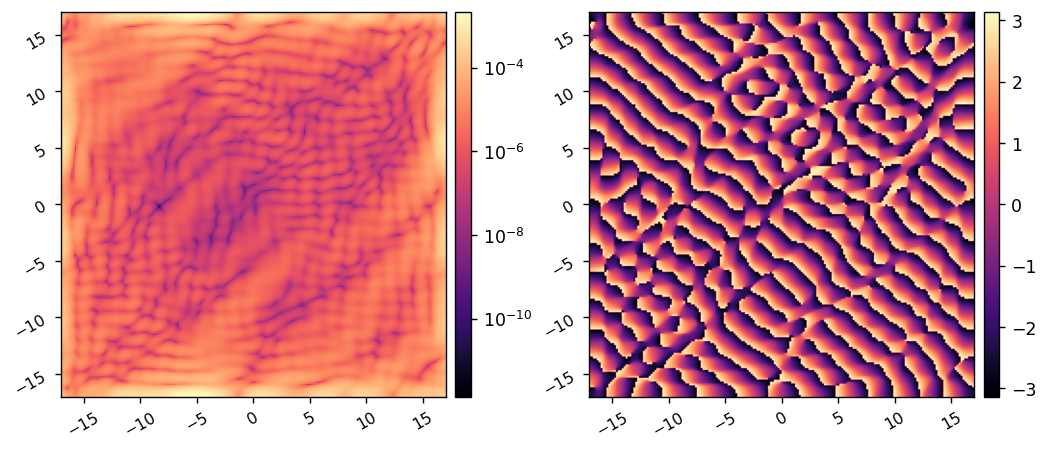

In [35]:
model.use_scc()
E_est = estimate_coherent(model, r_npix=18, shift=(37,37), plot=True)